In [1]:
import networkx as nx

from default import *
%cd -q {PROJECT_HOME}

In [2]:
import numpy as np
from dataset import AbstractHDF5Dataset
from typing import List, Callable
import torch, h5py
from models.architecture import MLP
from torch_geometric.data import Data, Batch
from torch.utils.data import DataLoader

/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <F3D74FBB-3B63-334B-BCDC-1C4C7C938BE8> /Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <E3D17B4A-4867-3D49-BC92-E04C28EE0F45> /Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aflamant/miniconda3/envs/memoire/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/aflamant/miniconda3/envs/memoire/lib/python3

In [3]:
def process_batch(nodes_features, edges_features, adj_matrices):
    batch_graphs = []

    batch_size, n_nodes, node_feat_dim = nodes_features.shape
    _, _, edge_feat_dim = edges_features.shape  # No fixed `n_edges`

    for i in range(batch_size):
        x = nodes_features[i]  # (n_nodes, node_feat_dim)
        adj = adj_matrices[i]  # (n_nodes, n_nodes)

        edge_index = adj.nonzero(as_tuple=False).t()  # (2, num_actual_edges)
        num_actual_edges = edge_index.shape[1]

        edge_attr = edges_features[i][:num_actual_edges]

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        batch_graphs.append(data)

    return Batch.from_data_list(batch_graphs)

In [4]:
class GraphPrattTrussDataset(AbstractHDF5Dataset):
    def __init__(self,
                 filepath: str,
                 f_noise_length: Callable[[int], float] | None = None,
                 f_noise_loads: Callable[[int], float] | None = None,
                 f_noise_strain: Callable[[int], float] | None = None,
                 f_noise_displacement: Callable[[int], float] | None = None,
                 dtype=torch.float32):

        super().__init__(filepath)

        # Noise configuration
        self.f_noise_length = f_noise_length
        self.f_noise_strain = f_noise_strain
        self.f_noise_displacement = f_noise_displacement
        self.f_noise_loads = f_noise_loads

        if f_noise_length is None:       self.f_noise_length = lambda size: np.ones(size)
        if f_noise_loads is None:        self.f_noise_loads = lambda size: np.ones(size)
        if f_noise_displacement is None: self.f_noise_displacement = lambda size: np.ones(size)
        if f_noise_strain is None:       self.f_noise_strain = lambda size: np.ones(size)

        # Database extraction
        self.dtype = dtype
        with h5py.File(filepath, 'r') as f:
            self.height = f['height'][:].astype(np.float64)
            self.length = f['length'][:].astype(np.float64)
            self.n_panels = f['n_panels'][:].astype(np.int64)
            self.nodes_coordinate = np.vstack(f['nodes_coordinate'][:], dtype=np.float64)
            self.nodes_displacement = np.vstack(f['nodes_displacement'][:], dtype=np.float64)
            self.load = np.vstack(f['nodes_load'][:], dtype=np.float64)
            self.bars_area = np.vstack(f['bars_area'][:], dtype=np.float64)
            self.bars_young = np.vstack(f['bars_young'][:], dtype=np.float64)
            self.bars_force = np.vstack(f['bars_force'][:], dtype=np.float64)
            self.bars_length_init = np.vstack(f['bars_length_init'][:], dtype=np.float64)
            self.bars_elongation = np.vstack(f['bars_elongation'][:], dtype=np.float64)
            self.bars_strain = np.vstack(f['bars_strain'][:], dtype=np.float64)
            self.stiffness_matrix = np.vstack(f['stiffness_matrix'][:], dtype=np.float64)
            self.connectivity_matrix = np.vstack(f['connectivity_matrix'][:], dtype=np.float64).reshape(
                (len(self.height), -1, 2))

        n_nodes = self.nodes_coordinate.shape[1]//2
        n_dof = 2
        nodes = self.nodes_coordinate.reshape((-1,n_nodes,2))
        elems = self.connectivity_matrix

        elems_vec = np.array([[nodes[i][int(e)] - nodes[i][int(s)] for s, e in elem] for i, elem in enumerate(elems)])

        elems_angle = np.array([[np.arctan2(*v[::-1]) - np.arctan2(0, 1) for v in elems_vec_i] for elems_vec_i in elems_vec])

        def to_first_quadrant(angles):
            angles = np.mod(angles, 2 * np.pi)  # Normalize to [0, 2π)
            first_quad_angles = np.where(
                angles <= np.pi/2, angles,
                np.where(
                    angles <= np.pi, np.pi - angles,
                    np.where(
                        angles <= 3*np.pi/2, angles - np.pi,
                        2*np.pi - angles
                    )
                )
            )
            return first_quad_angles

        self.elems_angle = to_first_quadrant(elems_angle)

        """
        self.adjacency_matrix = np.zeros((len(self.height), 16, 16), dtype=np.int32)
        for i in range(len(self.adjacency_matrix)):
            src, tgt = self.connectivity_matrix[i, :, 0], self.connectivity_matrix[i, :, 1]
            self.adjacency_matrix[i, src, tgt] = 1
            self.adjacency_matrix[i, tgt, src] = 1
        self.adjacency_matrix[:, np.arange(16), np.arange(16)] = 1

        self.degree = np.sum(self.adjacency_matrix, axis=1, dtype=np.int32)
        """

        # Could be improved
        self.noise_length = self.f_noise_length(self.height.shape)
        self.noise_truss_width = self.f_noise_length(self.length.shape)
        self.noise_bars_length_init = self.f_noise_length(self.bars_length_init.shape)
        self.noise_nodes_displacement = self.f_noise_displacement(self.nodes_displacement.shape)
        self.noise_load = self.f_noise_loads(self.load.shape)
        noise = self.f_noise_strain(self.bars_force.shape)
        self.noise_bars_force = noise
        self.noise_bars_strain = noise
        self.noise_bars_elongation = noise

    def __getitems__(self, idxs: List[int]):
        batch_graphs = []
        target = []
        for idx in idxs:
            n_nodes = len(self.nodes_coordinate[0]) // 2

            coord = self.nodes_coordinate[idx].reshape((-1, 2))
            disp = self.nodes_displacement[idx].reshape((-1, 2))
            load = self.load[idx, 1::2].reshape((-1, 1))
            support = np.zeros_like(coord)
            support[0, 0] = 1.
            support[[0, 8], 1] = 1.

            nodes_features = torch.tensor(np.concatenate((coord, disp, load, support), axis=-1), dtype=self.dtype)
            edges_features = torch.tensor(np.concatenate(
                (
                    self.bars_strain[idx].reshape((-1, 1)),
                    self.bars_length_init[idx].reshape((-1, 1)),
                    self.elems_angle[idx].reshape((-1,1)),
                    np.cos(self.elems_angle[idx].reshape((-1,1)))**2,
                    np.sin(self.elems_angle[idx].reshape((-1,1)))**2,
                    np.cos(self.elems_angle[idx].reshape((-1,1))) * np.sin(self.elems_angle[idx].reshape((-1,1)))
                 ),
                axis=1
            ), dtype=self.dtype)
            adj_matrices = torch.tensor(self.connectivity_matrix[idx], dtype=torch.int64).t()

            data = Data(x=nodes_features, edge_index=adj_matrices, edge_attr=edges_features)
            batch_graphs.append(data)

        G = Batch.from_data_list(batch_graphs)
        target = torch.tensor(self.bars_area[idxs] * self.bars_young[idxs], dtype=self.dtype).reshape((-1, 1))

        return G, target

    def __len__(self):
        return self.height.__len__()

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import math


def visualize_all_graphs(batch_data, k=1000., it=100, seed=42):
    """
    Converts a batch of PyG graphs to NetworkX graphs and visualizes all of them.

    Args:
    - batch_data: PyTorch Geometric Batch object
    """
    num_graphs = batch_data.batch.max().item() + 1  # Count of unique graphs
    cols = math.ceil(math.sqrt(num_graphs))  # Arrange in a square grid
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for batch_idx in range(num_graphs):
        mask = batch_data.batch == batch_idx  # Select nodes from batch
        x = batch_data.x[mask]  # Node features (not used for visualization)
        edge_index = batch_data.edge_index  # Global edge index
        edge_attr = batch_data.edge_attr  # Edge features

        # Filter edges belonging to the selected graph
        node_indices = torch.where(mask)[0]  # Get node indices in global batch
        edge_mask = torch.isin(edge_index[0], node_indices) & torch.isin(edge_index[1], node_indices)
        edge_index_filtered = edge_index[:, edge_mask]  # Filter edges
        edge_attr_filtered = edge_attr[edge_mask]  # Filter edge attributes

        # Normalize node indices (so they start at 0)
        node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}
        edge_index_filtered = torch.tensor([[node_mapping[n.item()] for n in edge_index_filtered_row]
                                            for edge_index_filtered_row in edge_index_filtered])

        # Create a NetworkX graph
        G = nx.Graph()
        for node in range(len(node_indices)):
            G.add_node(node)
        for i in range(edge_index_filtered.shape[1]):
            src, dst = edge_index_filtered[:, i].tolist()
            G.add_edge(src, dst, weight=edge_attr_filtered[i].mean().item())

        # Draw the graph
        ax = axes[batch_idx]

        # Get initial 2D coordinates from batch_data.x

        initial_pos = {i: batch_data.x[node_indices[i], :2].numpy() for i in range(len(node_indices))}
        pos = nx.spring_layout(G, k=k, pos=initial_pos, weight=None, iterations=it, seed=seed)

        color = ['lightblue', 'yellow', 'orange']
        color = [color[int(batch_data.x[node_indices[i], -2:].numpy().sum())] for i in range(len(node_indices))]
        nx.draw(G, pos, with_labels=True, node_color=color, edge_color='gray',
                node_size=200, font_size=8, ax=ax)
        ax.set_title(f"Graph {batch_idx}")

    # Hide unused subplots
    for i in range(num_graphs, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import MessagePassing


class MessagePassingLayer(MessagePassing):
    def __init__(self, message_fn, update_fn, aggr: str = 'mean'):
        """
        %TODO
        Parameters
        ----------
        message_fn: a 2*message_dim+edge_dim to message_dim differentiable function
        update_fn: a node_dim+message_dim to message_dim differentiable function
        aggr: aggregation mode as per MessagePassing documentation
        """
        super(MessagePassingLayer, self).__init__(aggr=aggr)

        self.message_fn = message_fn
        self.update_fn = update_fn

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        """Constructs messages from neighbors."""
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=-1)  # (num_edges, 2*hidden_dim + edge_dim)
        return self.message_fn(msg_input)

    def update(self, aggr_out, x):
        """Updates node embeddings."""
        return self.update_fn(torch.cat([x, aggr_out], dim=-1))


# Define the GNN Model
class GNN(nn.Module):
    def __init__(self, node_dim, message_dim, edge_dim, out_hidden_dims, out_dim, n_message_passing=2, aggr='mean',
                 act=nn.ReLU()):
        super(GNN, self).__init__()

        self.node_encoder = nn.Sequential(
            nn.Linear(node_dim, message_dim),
            nn.ReLU(),
            nn.Linear(message_dim, message_dim),
            nn.ReLU(),
            nn.Linear(message_dim, message_dim)
        )

        self.n_message_passing = n_message_passing
        self.gnn = MessagePassingLayer(
            message_fn=nn.Sequential(
                nn.Linear(message_dim * 2 + edge_dim, message_dim),
                nn.ReLU(),
                nn.Linear(message_dim, message_dim),
                nn.ReLU(),
                nn.Linear(message_dim, message_dim)
            ),
            update_fn=nn.Sequential(
                nn.Linear(2 * message_dim, message_dim),
                nn.ReLU(),
                nn.Linear(message_dim, message_dim),
                nn.ReLU(),
                nn.Linear(message_dim, message_dim)
            ),
            aggr=aggr
        )

        # Output MLP
        dims = [message_dim * 2 + edge_dim, *out_hidden_dims, out_dim]
        self.mlp_out = nn.Sequential()

        for i in range(len(dims) - 2):
            self.mlp_out.append(nn.Linear(dims[i], dims[i + 1]))
            self.mlp_out.append(act)

        self.mlp_out.append(nn.Linear(dims[-2], dims[-1]))

    def forward(self, x, edge_index, edge_attr):
        h = self.node_encoder(x)

        for _ in range(self.n_message_passing):
            h = self.gnn(h, edge_index, edge_attr)  # (num_nodes, hidden_dim)

        # Edge-level prediction: concatenate node embeddings & edge features
        src, dst = edge_index  # Get source & destination node indices
        edge_repr = torch.cat([h[src], h[dst], edge_attr], dim=-1)  # (num_edges, 2*hidden_dim + hidden_dim)

        return self.mlp_out(edge_repr)  # (num_edges, out_dim)

In [7]:
from models.processing import StandardScaler
import torchmetrics.functional.regression as R

batch_size = 32

ds = GraphPrattTrussDataset("data/dataset/pratt_truss_bridge/multiple_ea/train_1024.hdf5")
ds_test = GraphPrattTrussDataset("data/dataset/pratt_truss_bridge/multiple_ea/train_2048.hdf5")
idx = np.random.shuffle(np.arange(len(ds)))

scaler_node = StandardScaler(7)
scaler_edge = StandardScaler(6)
scaler_target = StandardScaler(1)

G, y = ds[:100]

scaler_node.fit(G.x)
scaler_edge.fit(G.edge_attr)
scaler_target.fit(y)

node_feat_dim = G.x.shape[-1]
edge_feat_dim = G.edge_attr.shape[-1]
message_dim = 256
out_dim = 1  # Predicting a single edge feature

# Create model
model = GNN(node_dim=node_feat_dim,
            message_dim=message_dim,
            edge_dim=edge_feat_dim,
            out_hidden_dims=[64, 32, 16],
            out_dim=out_dim,
            n_message_passing=3,
            aggr='mul',
            act=nn.Tanh())

#model = GNN(node_dim=node_feat_dim, edge_dim=edge_feat_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = optim.Adam(model.parameters(), lr=2.0e-3)
criterion = nn.MSELoss()
last_loss = np.inf

total_no_improvement = 0
no_improvment_stop = 50
no_improvment = 0
no_improvment_step = 25

train_loss_hist = []
val_loss_hist = []
val_mape_hist = []
val_r2_hist = []
for epoch in range(200):
    loss_epoch = []
    for i in range(int(np.ceil(len(ds) / batch_size))):
        optimizer.zero_grad()

        # Convert batch to PyG format
        batch_data, target = ds[i * batch_size:min((i + 1) * batch_size, len(ds))]

        batch_data.x = scaler_node.transform(batch_data.x)
        batch_data.edge_attr = scaler_edge.transform(batch_data.edge_attr)
        target = scaler_target.transform(target)

        # Forward pass
        predictions = model(batch_data.x, batch_data.edge_index, batch_data.edge_attr)

        # Compute loss
        loss = criterion(predictions, target)  # Match shapes dynamically

        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())

    v = np.mean(loss_epoch)
    if np.isnan(v):
        raise ValueError()
    train_loss_hist.append(np.mean(loss_epoch))

    loss_epoch = []
    mape_epoch = []
    r2_epoch = []
    for i in range(int(np.ceil(len(ds_test) / batch_size))):
        with torch.no_grad():
            # Convert batch to PyG format
            batch_data, target = ds_test[i * batch_size:min((i + 1) * batch_size, len(ds_test))]

            batch_data.x = scaler_node.transform(batch_data.x)
            batch_data.edge_attr = scaler_edge.transform(batch_data.edge_attr)
            target = scaler_target.transform(target)

            # Forward pass
            predictions = model(batch_data.x, batch_data.edge_index, batch_data.edge_attr)

            # Compute loss
            val_loss = criterion(predictions, target)  # Match shapes dynamically

            val_mape = R.mean_absolute_percentage_error(scaler_target.inverse_transform(predictions),
                                                        scaler_target.inverse_transform(target))
            val_r2 = R.r2_score(scaler_target.inverse_transform(predictions),
                                scaler_target.inverse_transform(target))

            loss_epoch.append(val_loss)
            mape_epoch.append(val_mape)
            r2_epoch.append(val_r2)

    val_loss_hist.append(np.mean(loss_epoch))
    val_mape_hist.append(np.mean(mape_epoch))
    val_r2_hist.append(np.mean(r2_epoch))

    if val_mape < last_loss:
        last_loss = val_mape
        print(
            f"Epoch {epoch + 1: 4d}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val R2: {val_r2.item():.4f}, Val MAPE: {val_mape.item():.4f}")
        no_improvment = 0
        total_no_improvement = 0
    else:
        no_improvment += 1
        total_no_improvement += 1

    if total_no_improvement >= no_improvment_stop:
        print("Early stop")
        break

    if no_improvment == no_improvment_step:
        no_improvment = 0
        for g in optimizer.param_groups:
            g['lr'] /= 2.
        print(f"   LR reduced")

Epoch    1, Loss: 1.0599, Val Loss: 0.9009, Val R2: 0.1027, Val MAPE: 1.2975
Epoch    2, Loss: 0.8406, Val Loss: 0.7206, Val R2: 0.2824, Val MAPE: 0.9001
Epoch    3, Loss: 0.7332, Val Loss: 0.6925, Val R2: 0.3103, Val MAPE: 0.7471
Epoch    6, Loss: 0.6063, Val Loss: 0.5448, Val R2: 0.4574, Val MAPE: 0.7218
Epoch    7, Loss: 0.5666, Val Loss: 0.5301, Val R2: 0.4720, Val MAPE: 0.6204
Epoch    8, Loss: 0.5551, Val Loss: 0.5203, Val R2: 0.4818, Val MAPE: 0.6073
Epoch   10, Loss: 0.4856, Val Loss: 0.4772, Val R2: 0.5247, Val MAPE: 0.5536
Epoch   11, Loss: 0.4208, Val Loss: 0.4303, Val R2: 0.5714, Val MAPE: 0.5188
Epoch   12, Loss: 0.3772, Val Loss: 0.3527, Val R2: 0.6488, Val MAPE: 0.4787
Epoch   13, Loss: 0.3843, Val Loss: 0.3848, Val R2: 0.6168, Val MAPE: 0.4402
Epoch   14, Loss: 0.3097, Val Loss: 0.2949, Val R2: 0.7063, Val MAPE: 0.4183
Epoch   15, Loss: 0.3181, Val Loss: 0.3254, Val R2: 0.6759, Val MAPE: 0.3695
Epoch   16, Loss: 0.2946, Val Loss: 0.2838, Val R2: 0.7173, Val MAPE: 0.3562

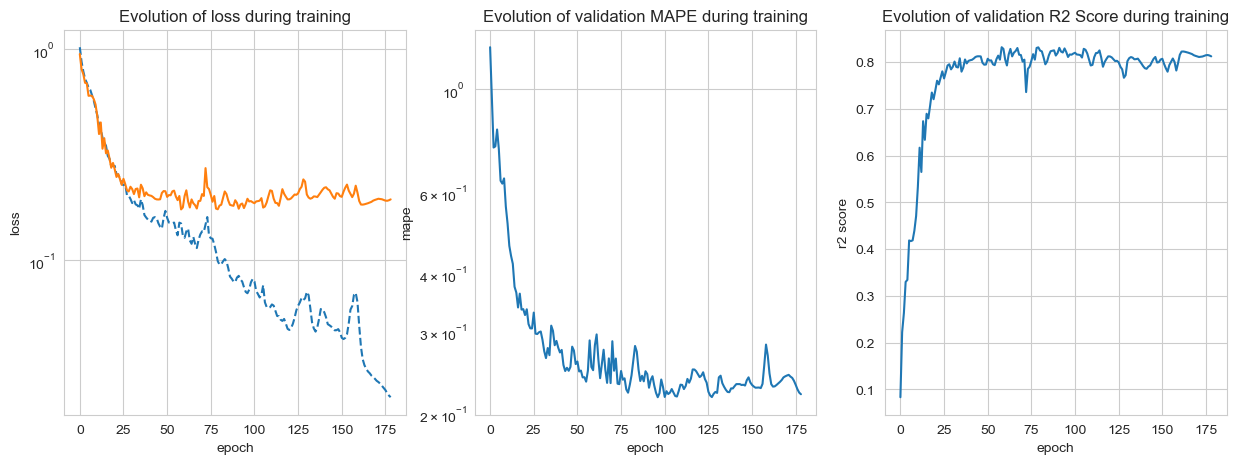

In [8]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].plot(train_loss_hist, linestyle='--')
axs[0].plot(val_loss_hist, linestyle='-')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('Evolution of loss during training')

axs[1].plot(val_mape_hist, linestyle='-')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('mape')
axs[1].set_title('Evolution of validation MAPE during training')

axs[2].plot(val_r2_hist, linestyle='-')
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('r2 score')
axs[2].set_title('Evolution of validation R2 Score during training')

for ax in axs[:2]:
    ax.set_yscale('log')

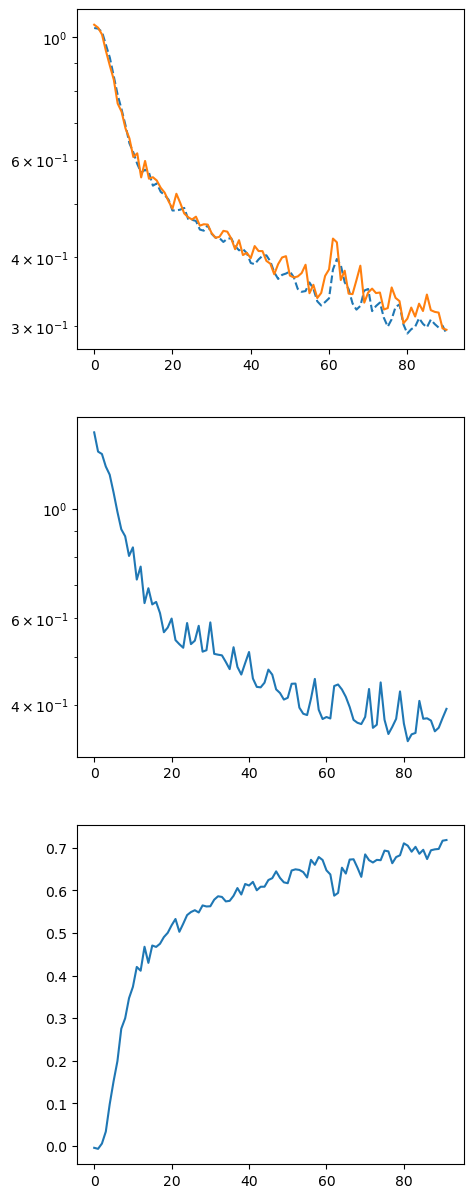

In [78]:
fig, axs = plt.subplots(3, figsize=(5, 15))
axs[0].plot(train_loss_hist[1:], linestyle='--')
axs[0].plot(val_loss_hist[1:], linestyle='-')
axs[1].plot(val_mape_hist, linestyle='-')
axs[2].plot(val_r2_hist, linestyle='-')
for ax in axs[:2]:
    ax.set_yscale('log')

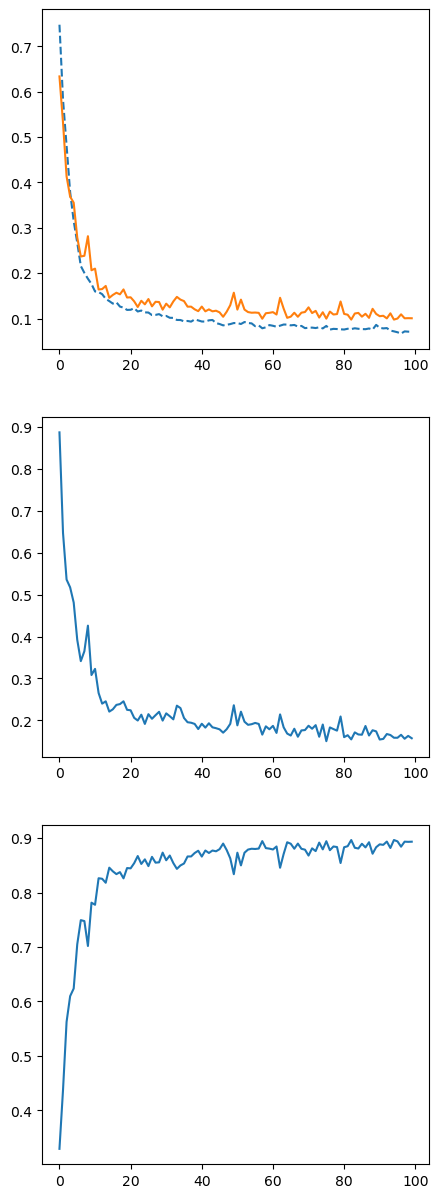

In [60]:
fig, axs = plt.subplots(3, figsize=(5, 15))
axs[0].plot(train_loss_hist, linestyle='--')
axs[0].plot(val_loss_hist, linestyle='-')
axs[1].plot(val_mape_hist, linestyle='-')
axs[2].plot(val_r2_hist, linestyle='-')
for ax in axs[:3]:
    continue
    ax.set_yscale('log')